<a href="https://colab.research.google.com/github/Leop250/reseaux_neurones/blob/main/code_clean_tp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import**

In [ ]:
import os                                                                       #permet de créer un dossier/fichier pour sauvgarder notre jeu de donnéees normalisé
import numpy as np                                                              #utilisé pour les arrays et les opérations
import zipfile                                                                  #lire un zip
from google.colab import drive                                                  #récupérer des infos dans le drive
import shutil                                                                   #extraire file
import matplotlib.pyplot as plt                                                 #affichage de graphique
from PIL import Image                                                           #datagen image
#modele
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
#from tensorflow.keras.applications.resnet50 import preprocess_input
#from tensorflow.keras.application.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, GlobalMaxPooling2D,Flatten
from tensorflow.keras.models import Model


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **2. Fonctions**

In [ ]:
def mount_drive():
    drive.mount('/content/drive')                                               # Permet de se conecter au drive

In [ ]:
def extract_dataset(zip_path, extract_path):                                    #Fonction qui permet d'extraire les fichiers d'un fichier Zip
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:                             #Lire le fichier zip
        zip_ref.extractall(extract_path)                                        #Extraire les fichiers dans le dossier spécifié
    print(f"Fichiers extraits dans : {extract_path}")                           # Affiche la confirmation d'extration du fichier

In [ ]:
def load_images(parasitized_dir, uninfected_dir, img_size=64):                  #charge images, normalise prenant en entrée le rep des celulles malades, saines et par défaut une img de taille 64
    images, labels = [], []                                                     #init des listes pour les images et labels
    for label, directory in zip([1, 0], [parasitized_dir, uninfected_dir]):
        for filename in os.listdir(directory):
            if filename.endswith(".png"):
                img_path = os.path.join(directory, filename)
                img = Image.open(img_path).resize((img_size, img_size))
                img = np.array(img) / 255.0
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
def augment_data(X_train, y_train):                                             # Fonction du data Generateur qui permet de "Augmenter la préciser " en génerant de nouvel images
    datagen = ImageDataGenerator(                                               # Creation du Data Generateur
        rotation_range=20,                                                      # Fait une rotation de L'image
        width_shift_range=0.2,                                                  # Décale l'image horizontalement
        height_shift_range=0.2,                                                 # Décale l'image horizontalement et verticalement
        horizontal_flip=True,                                                   # Fait un flip de l'image
        zoom_range=0.2,                                                         # Zoom l'image
        shear_range=0.2                                                         # Déplace les pixels de l'image
    )
    datagen.fit(X_train)                                                        # Applique les transformations aux données d'entraînement
    return datagen                                                              # Retourne le data generateur

In [ ]:
def display_augmented_images(datagen, X_train):                                 # Fonction qui permet d'afficher les images augmentées
    it = datagen.flow(X_train[:5], batch_size=1)                                # Récupère les 5 premières images du jeu de données d'entraînement
    fig, axes = plt.subplots(1, 5, figsize=(10, 5))                             # Cree et configurations des AXES
    for i in range(5):                                                          # Boucle sur les 5 images
        batch = next(it)
        axes[i].imshow(batch[0])                                                # Affiche l'image augmentée
        axes[i].axis('off')                                                     # Desactives les Axes
    plt.show()                                                                  # Affiche la figure

In [ ]:
## model resnet 50
def build_resnet50_model(input_shape=(64, 64, 3)):                              #creation du model resnet
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)  # Configuration du model Resnet 50 le wheigts congiuration du poid de l'image. include_top = False signifie que
    base_model.trainable = False                                                # Gèle les couches du modèle de base pour conserver les poids pré-entraînés pendant l'entraînement.
    x = GlobalMaxPooling2D()(base_model.output)                                 # Ajoute une couche de Global Average Pooling pour réduire les dimensions spatiales de la sortie du modèle de base.
    x = Flatten()(x)
    x = Dense(64, activation="relu")(x)                                         # Ajoute une couche dense avec 64 neurones et une activation ReLU.
    x = Dropout(0.2)(x)                                                         # Ajoute une couche de dropout pour régulariser les données.
    x = Dense(1, activation="sigmoid")(x)                                       # Ajoute une dernière couche dense avec une activation sigmoïde pour la sortie du modèle.
    model = Model(inputs=base_model.input, outputs=x)                           # Définit le modèle avec l'entrée du modèle de base et la sortie de la dernière couche Dense du résaux de neurone
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])   # Compile le modèle avec la perte d'entropie croisée binaire, l'optimiseur Adam et la précision comme métrique d'évaluation.
    return model

In [ ]:
## model from scratch
def build_fs_model(input_shape=(64, 64, 3)):                                 #Construcition du model Vgg16 avce les images en inputs 64,64,3
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D((2, 2)),                                       #Ajoute une couche de convolution avec 64 filtres de taille 3x3, activation ReLU, et la forme d'entrée spécifiée.
        keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D((2, 2)),                                      #Ajoute une couche de max pooling avec une taille de fenêtre de 2x2.
        keras.layers.Conv2D(128, (3, 3), activation='relu'),                     #Ajoute une autre couche de convolution avec 64 filtres de taille 3x3 et activation ReLU
        keras.layers.MaxPooling2D((2, 2)),                                     #Ajoute une autre couche de max pooling avec une taille de fenêtre de 2x2.
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),                                                 #Applatit la sortie de la couche précédente en un vecteur
        keras.layers.Dense(128, activation='relu'),                              #Ajoute une couche dense avec 64 neurones et une activation ReLU.                                          #Ajout du dropout aide à éviter que le modèle ne mémorise simplement les données d'entraînement,
        keras.layers.Dense(1, activation='sigmoid')                             # Ajoute la couche Dense finale avec 1 unité et activation sigmoïde pour la classification binaire. (Malade ou non Malade)
    ])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [ ]:
#from scractch sequential
def squential_from_scratch(input_shape=(64, 64, 3)):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=input_shape),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, datagen, epochs=50, batch_size=32): #Fonction pour entrainer le model
    def scheduler(epoch, lr):                                                   # Définit un planificateur de taux d'apprentissage qui réduit le taux d'apprentissage après 5 époques.
        return lr if epoch < 5 else lr * np.exp(-0.1)
    callbacks = [
        keras.callbacks.LearningRateScheduler(scheduler),                       # Applique le planificateur de taux d'apprentissage à chaque époque.
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True) #Arrêt précoce pour éviter le surapprentissage.
    ]
    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),  #Entraîne le modèle en utilisant le générateur d'augmentation des données.
                        validation_data=(X_val, y_val),                         #Validation set
                        epochs=epochs,                                          #Nombre d'époques
                        batch_size=batch_size,                                  #Taille du lot
                        callbacks=callbacks)                                    #Liste des callbacks.
    return history

In [ ]:
def plot_loss(history):                                                         #Fonctin pour afficher les graphiques
    plt.plot(history.history["loss"], label="Train Loss")                       #Affiche la courbe de perte d'entraînement
    plt.plot(history.history["val_loss"], label="Validation Loss")              #Affiche la courbe de perte de validation
    plt.title("Loss")                                                           #Titre du graphique
    plt.xlabel("Epoch")                                                         #Nom de l'axe des x
    plt.ylabel("Loss")                                                          #Nom de l'axe des y
    plt.legend()                                                                #Affiche la légende
    plt.show()                                                                  #Affiche le graphique

In [ ]:
def threshold(model, x, y):                                                     # Fonction pour calculer le seuil optimal
    y_scores = model.predict(x)[:, 0]                                           # Prédit les scores de probabilité de classe
    fpr, tpr, thresholds = roc_curve(y, y_scores)                               # Calcule la courbe ROC et les seuils
    optimal_idx = np.argmax(tpr - fpr)                                          #Al'aide de numpy calcul l'optimal_idx
    return thresholds[optimal_idx]                                              #Retourne le seuil optimal

In [ ]:
def plot_roc_curve(model, X_test, y_test):                                      # Fonction pour afficher la courbe ROC
    y_pred_prob = model.predict(X_test)                                         # Prédit les probabilités de classe
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)                                #Calcul de le roc pour les y_test, x_test
    roc_auc = auc(fpr, tpr)                                                     #Calcul de l'auc
    optimal_threshold = threshold(model, X_test, y_test)                        #Calcul du seuil optimal
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')                #Affiche la courbe ROC
    plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)],           #Affiche le suil Optmial
                color='red', label=f'Seuil optimal = {optimal_threshold:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')                      #Affiche la ligne du hasar
    plt.xlabel("False Positive Rate")                                           #Affiche le titre de l'axe des Y
    plt.ylabel("True Positive Rate")                                            #Affiche le titre de l'axe des X
    plt.legend()                                                                #Affiche la légende
    plt.show()                                                                  #Affiche le ke graphique
    return optimal_threshold                                                    #Retourne le seuil optimal

In [ ]:
def evaluate_model(model, X_test, y_test):                                      # Fonction pour évaluer le modèle
    y_pred = (model.predict(X_test) > 0.5).astype("int32")                      # Prédit les classes de l'ensemble de test sur forme de 32 bits
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")                        #Affiche Accuracy
    print(f"Precision: {precision_score(y_test, y_pred)}")                      #Affiche Precision
    print(f"Recall: {recall_score(y_test, y_pred)}")                            #Affiche Recall
    print(f"F1-Score: {f1_score(y_test, y_pred)}")                              #Affiche F1-Score

In [ ]:
def plot_confusion_matrix(model, X_test, y_test):                               # Fonction pour afficher la matrice de confusion
    y_pred = (model.predict(X_test) > 0.5).astype("int32")                      # Prédit les classes de l'ensemble de test sur forme de 32 bits
    cm = confusion_matrix(y_test, y_pred)                                       #Calcule la matrice de confusion
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non infecté", "Infecté"])
    cm_display.plot(cmap="Blues")                                               # Utilisation d'une colormap bleue
    plt.title("Matrice de confusion")                                           #Titre de la matrice de confusion
    plt.show()                                                                  #Affiche la matrice de confusion

In [ ]:

def build_model_vgg16(input_shape=(64, 64, 3)):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
  for layer in base_model.layers:
      layer.trainable = False
  x = base_model.output
  x = GlobalMaxPooling2D()(x)
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.25)(x)
  predictions = Dense(1, activation='sigmoid')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model
  model.summary()


# **3. Chargement et séparation des données (à exécuter une seule fois)**


In [ ]:
mount_drive()                                                                   #Permet de se contecter au drive
zip_path = "/content/drive/MyDrive/malaria/Copie de malaria_hematie_dataset.zip" #Emplacement du fichier actuel
extract_path = "/content/malaria_hematie_dataset"                               #Lieu ou on vas extraire le fichier ZIP
extract_dataset(zip_path, extract_path)                                         #Extraction

dataset_dir = os.path.join(extract_path, "malaria_hematie_dataset")             # Attribution du dataset a une variable
parasitized_dir = os.path.join(dataset_dir, "parasitized")                      # Attribution des parasities a une variable
uninfected_dir = os.path.join(dataset_dir, "uninfected")                        # Attribution des non parasities a une variable

images, labels = load_images(parasitized_dir, uninfected_dir)                    # Chargement des images et des labels

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42) #Separation des images en train et en test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")                                 #Verification de la tailles des Shapes valeurs
print(f"Validation set size: {X_val.shape[0]}")                                 #Verification de la tailles des Shapes valeurs
print(f"Test set size: {X_test.shape[0]}")                                      #Verification de la tailles des Shapes valeurs

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fichiers extraits dans : /content/malaria_hematie_dataset
Training set size: 17636
Validation set size: 4410
Test set size: 5512




```
# Ce texte est au format code
```

# **4. Entrainement du modèle**

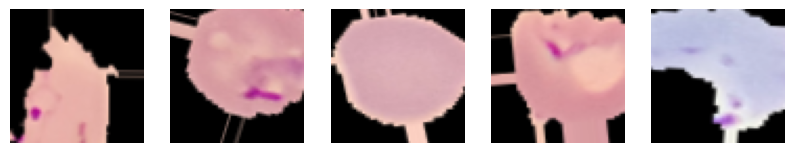

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


552/552 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/step - accuracy: 0.6548 - loss: 0.5849 - val_accuracy: 0.9404 - val_loss: 0.1851 - learning_rate: 0.0010
Epoch 2/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.9039 - loss: 0.2669 - val_accuracy: 0.9444 - val_loss: 0.1827 - learning_rate: 0.0010
Epoch 3/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.9109 - loss: 0.2478 - val_accuracy: 0.9535 - val_loss: 0.1643 - learning_rate: 0.0010
Epoch 4/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - accuracy: 0.9153 - loss: 0.2399 - val_accuracy: 0.9506 - val_loss: 0.1683 - learning_rate: 0.0010
Epoch 5/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - accuracy: 0.9226 - loss: 0.2214 - val_accuracy: 0.9551 - val_loss: 0.1565 - learning_rate: 0.0010
Epoch 6/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.9286 - loss: 0.2068 - val_accuracy: 0.9553 - val_loss: 0.1413 - learning_rate: 9.0484e-04
Epoch 7/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.9270 - loss: 0.

In [ ]:
datagen = augment_data(X_train, y_train)                                        # Augmentation des données d'entraînement
display_augmented_images(datagen, X_train)                                      # Affichage des images augmentées

fs_model = build_fs_model(input_shape=(64, 64, 3))                       #Construction du model VGG16 en appelant la fonction
history_vgg = train_model(fs_model, X_train, y_train, X_val, y_val, datagen)#Affichage de l'hystoriques des données d'entrainel

resnet50_model= build_resnet50_model(input_shape=(64, 64, 3))                   #Construction du model REsnt50
history_resnet = train_model(resnet50_model, X_train, y_train, X_val, y_val, datagen) #Affichage de l'hystoriques des données d'entrainel


# fs_model.save_weights("/content/fs_model_weights.weights.h5")            # Saugarde du model VGG16
print("Les poids du modèle resnet50 ont été sauvegardés.")                          # Saugarde des données



In [ ]:

datagen = augment_data(X_train, y_train)                                        # Augmentation des données d'entraînement
#display_augmented_images(datagen, X_train)                                      # Affichage des images augmentées (optional)
vgg_16_model = build_model_vgg16(input_shape=(64, 64, 3))                       #Construction du model VGG16 en appelant la fonction
history_vgg_16 = train_model(vgg_16_model, X_train, y_train, X_val, y_val, datagen, epochs=50) #Affichage de l'hystoriques des données d'entrainel
vgg_16_model.save_weights("/content/vgg_16_model_weights.weights.h5")            # Saugarde du model VGG16
print("Les poids du modèle VGG16 ont été sauvegardés.")                          # Saugarde des données


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.8153 - loss: 0.4061 - val_accuracy: 0.9061 - val_loss: 0.2330 - learning_rate: 0.0010
Epoch 2/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - accuracy: 0.8627 - loss: 0.3259 - val_accuracy: 0.9156 - val_loss: 0.2179 - learning_rate: 0.0010
Epoch 3/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - accuracy: 0.8741 - loss: 0.3079 - val_accuracy: 0.9104 - val_loss: 0.2188 - learning_rate: 0.0010
Epoch 4/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - accuracy: 0.8824 - loss: 0.2983 - val_accuracy: 0.9172 - val_loss: 0.2102 - learning_rate: 0.0010
Epoch 5/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - accuracy: 0.8843 - loss: 0.2865 - val_accuracy: 0.9159 - val_loss: 0.2182 - learning_rate: 0.0010
Epoch 6/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.8862 - loss: 0.2901 - val_accuracy: 0.9211 - val_loss: 0.2056 - learning_rate: 9.0484e-04
Epoch 7/50
552/552 ━━

In [ ]:




def build_model_vgg16(input_shape=(64, 64, 3)):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
  for layer in base_model.layers:
      layer.trainable = False
  x = base_model.output
  x = GlobalMaxPooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.25)(x)
  predictions = Dense(1, activation='sigmoid')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model


# **5. Afficher les graphiques**

Les graphique FromScratch 


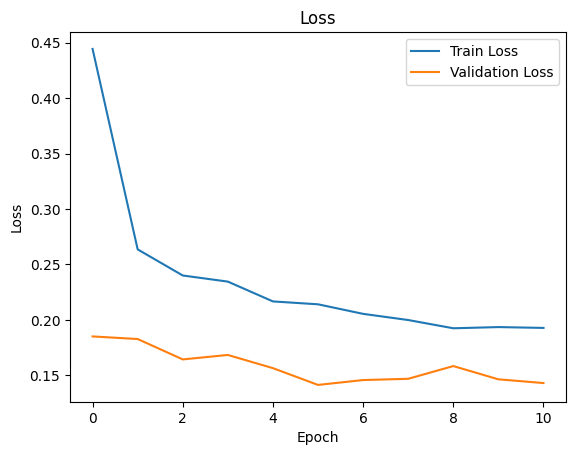

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


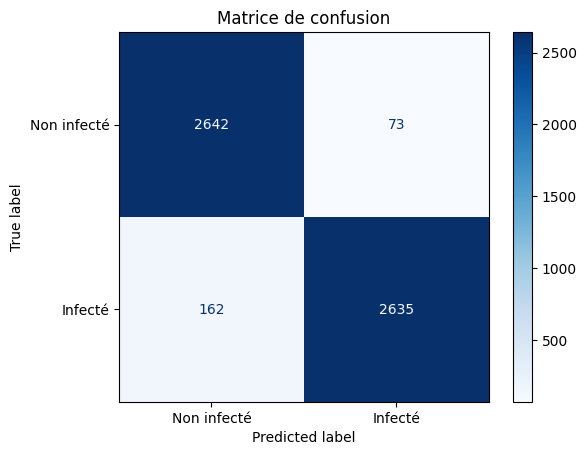

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


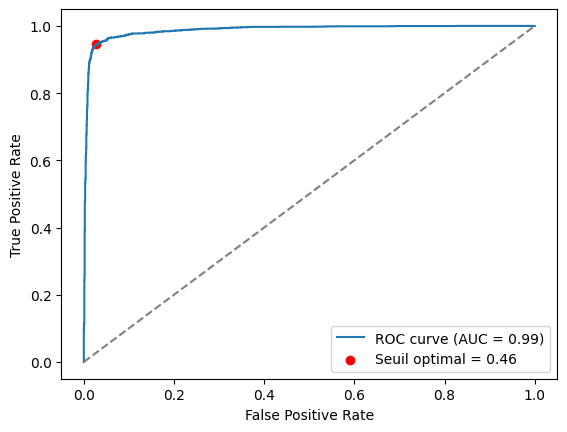

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


552/552 ━━━━━━━━━━━━━━━━━━━━ 49s 70ms/step - accuracy: 0.5674 - loss: 0.6818 - val_accuracy: 0.6408 - val_loss: 0.6404 - learning_rate: 0.0010
Epoch 2/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - accuracy: 0.6130 - loss: 0.6569 - val_accuracy: 0.5957 - val_loss: 0.6765 - learning_rate: 0.0010
Epoch 3/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - accuracy: 0.6249 - loss: 0.6488 - val_accuracy: 0.6283 - val_loss: 0.6351 - learning_rate: 0.0010
Epoch 4/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - accuracy: 0.6334 - loss: 0.6436 - val_accuracy: 0.6238 - val_loss: 0.6336 - learning_rate: 0.0010
Epoch 5/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - accuracy: 0.6303 - loss: 0.6423 - val_accuracy: 0.6848 - val_loss: 0.6040 - learning_rate: 0.0010
Epoch 6/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - accuracy: 0.6339 - loss: 0.6415 - val_accuracy: 0.6136 - val_loss: 0.6501 - learning_rate: 9.0484e-04
Epoch 7/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - accuracy: 0.6384 - loss: 0.

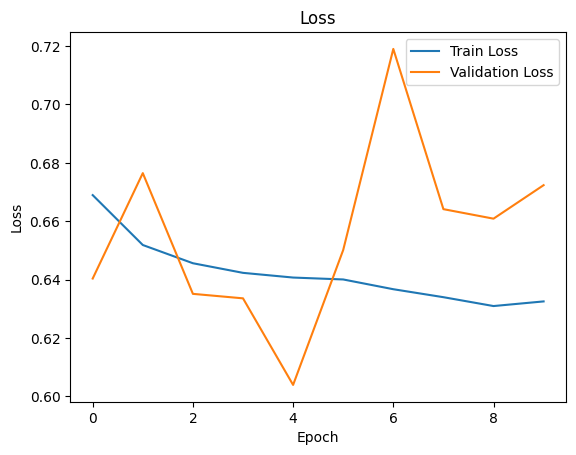

173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


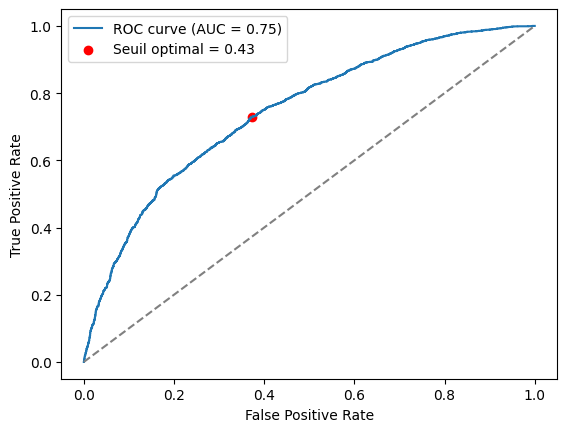

173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


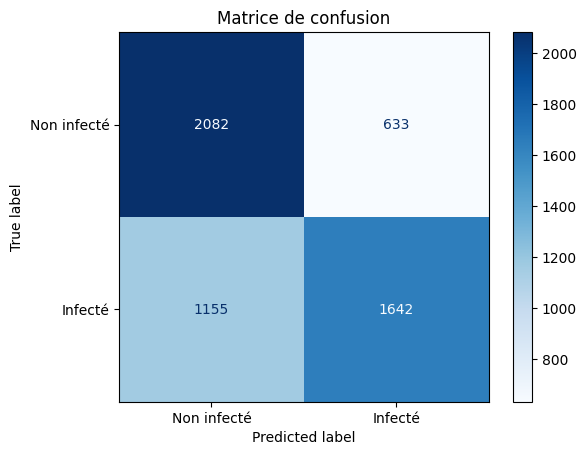

Les graphique VVG16


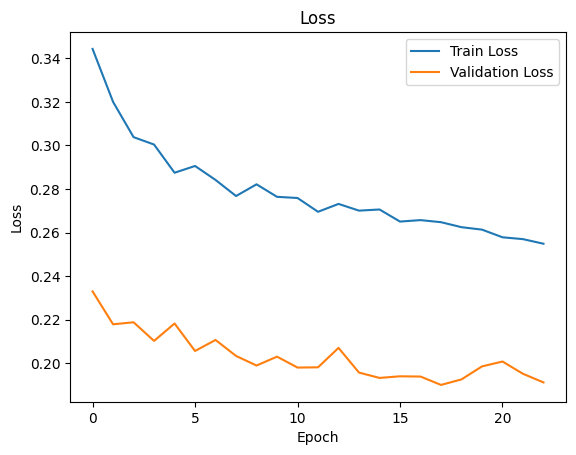

173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


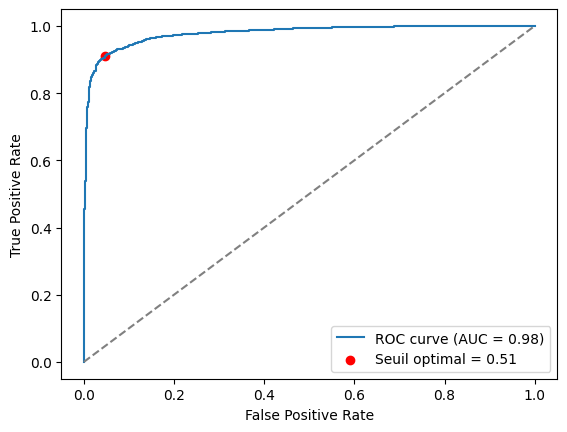

173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


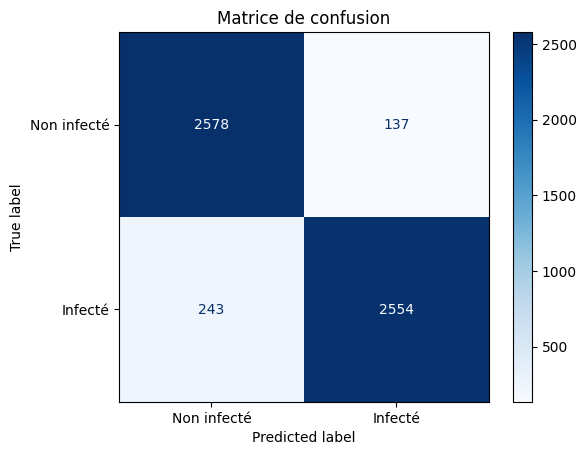

In [ ]:
print("Les graphique FromScratch ")
plot_loss(history_vgg)                                                          #Affichage de l'historiques  du model VVG16
plot_confusion_matrix(fs_model, X_test, y_test)                             #Affichage de la matrice de confusion
plot_roc_curve(fs_model, X_test, y_test)                                    # Affichage de la Roc curve

resnet50_model = build_resnet50_model(input_shape=(64, 64, 3))
history_resnet = train_model(resnet50_model, X_train, y_train, X_val, y_val, datagen) # Affichage de l'historique du model

print("Les graphique ResNet50")
plot_loss(history_resnet)                                                       # Affichage de l'historique du model
plot_roc_curve(resnet50_model, X_test, y_test)                                  # Affichage de la roc curve
plot_confusion_matrix(resnet50_model, X_test, y_test)                           # Affichage de la matrice de confusion


print("Les graphique VVG16")
plot_loss(history_vgg_16)                                                       # Affichage de l'historique du model
plot_roc_curve(vgg_16_model, X_test, y_test)                                  # Affichage de la roc curve
plot_confusion_matrix(vgg_16_model, X_test, y_test)                           # Affichage de la matrice de confusion

#evaluate_model(resnet50_model, X_test, y_test)
#plot_confusion_matrix(resnet50_model, X_test, y_test)

# Sauvegarde des poids du modèle ResNet50
#resnet50_model.save_weights("/content/resnet50_model_weights.h5")
#print("Les poids du modèle ResNet50 ont été sauvegardés.")

In [ ]:
# plot_loss(history_resnet)
# plot_roc_curve(resnet50_model, X_test, y_test)
# plot_confusion_matrix(resnet50_model, X_test, y_test)

In [ ]:
# datagen = augment_data(X_train, y_train)
# model_fs = build_fs_model(input_shape=(64, 64, 3))
# history_fs = train_model(model_fs, X_train, y_train, X_val, y_val, datagen)

# print("Les graphique History_fs")
# plot_loss(history_fs)
# plot_roc_curve(model_fs, X_test, y_test)
# plot_confusion_matrix(model_fs, X_test, y_test)
# evaluate_model(model_fs, X_test, y_test)
